In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

In [2]:
random_state = 2020
tr_rate = 0.7
ts_rate = 0.3
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
data_file = 'house_prices_train.csv'

In [3]:
data = pd.read_csv(data_file)
features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
            'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
            'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
            'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd']

y = np.log(data['SalePrice'])
x = data[features]

In [4]:
x.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YearRemodAdd
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,2,548,0,61,0,0,0,0,0,2003
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,...,2,460,298,0,0,0,0,0,0,1976
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,2,608,0,42,0,0,0,0,0,2002
3,60.0,9550,0.0,216,0,540,756,961,756,0,...,3,642,0,35,272,0,0,0,0,1970
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,3,836,192,84,0,0,0,0,0,2000


In [5]:
y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [6]:

tr_x, ts_x , tr_y, ts_y = train_test_split(x, y, test_size=ts_rate, random_state=random_state)
tr_x, vl_x, tr_y , vl_y = train_test_split(tr_x, tr_y, test_size=ts_rate, random_state=random_state)

print(tr_x.shape)
print(vl_x.shape)
print(ts_x.shape)

(715, 29)
(307, 29)
(438, 29)


In [7]:
model_params = dict(objective='quantile', max_depth=5, num_leaves=25, n_estimators=200, n_jobs=4)
quantiles = (0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95)
w = 0.1

qr_models = []
for q in quantiles:
    print(f'\n----<quantile point {q}>----')
    mdl = LGBMRegressor(alpha=q, **model_params)
    mdl.fit(tr_x, tr_y, eval_set=[(vl_x, vl_y)], early_stopping_rounds=10, verbose=20)
    qr_models.append(mdl)


----<quantile point 0.05>----
Training until validation scores don't improve for 10 rounds
[20]	valid_0's quantile: 0.0283909
[40]	valid_0's quantile: 0.0283793
Early stopping, best iteration is:
[36]	valid_0's quantile: 0.0281212

----<quantile point 0.15>----
Training until validation scores don't improve for 10 rounds
[20]	valid_0's quantile: 0.0517178
[40]	valid_0's quantile: 0.0460044
[60]	valid_0's quantile: 0.0451972
Early stopping, best iteration is:
[52]	valid_0's quantile: 0.0450633

----<quantile point 0.25>----
Training until validation scores don't improve for 10 rounds
[20]	valid_0's quantile: 0.063159
[40]	valid_0's quantile: 0.0549614
[60]	valid_0's quantile: 0.0535762
Early stopping, best iteration is:
[62]	valid_0's quantile: 0.0535208

----<quantile point 0.35>----
Training until validation scores don't improve for 10 rounds
[20]	valid_0's quantile: 0.0684835
[40]	valid_0's quantile: 0.0592363
[60]	valid_0's quantile: 0.0578429
[80]	valid_0's quantile: 0.0574649
Ear

In [8]:
# 分位点の予測値
tr_pred_qps = []
for mdl in qr_models:
    tr_pred_qps.append(mdl.predict(tr_x))

ts_pred_qps = []
for mdl in qr_models:
    ts_pred_qps.append(mdl.predict(ts_x))

# 予測値の平均、標準偏差を計算
def calc_ave_std(pred_quantile_points):
    pred_ave = np.zeros_like(pred_quantile_points[0])
    for pred in pred_quantile_points:
        pred_ave += w * pred

    pred_std = np.zeros_like(pred_quantile_points[0])
    for pred in pred_quantile_points:
        pred_std += w * (pred - pred_ave) ** 2
    pred_std = np.sqrt(pred_std)

    return pred_ave, pred_std

tr_pred_ave, tr_pred_std = calc_ave_std(tr_pred_qps)
ts_pred_ave, ts_pred_std = calc_ave_std(ts_pred_qps)

train
test


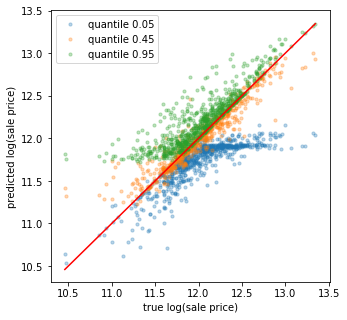

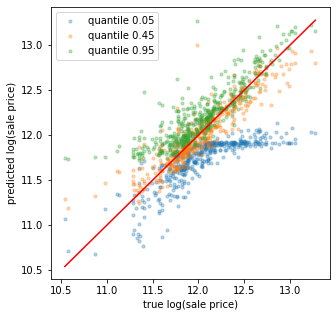

In [9]:
def plot_true_vs_pred(y_true, pred_list, labels):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))

    for pred, lbl in zip(pred_list, labels):
        ax.scatter(y_true, pred, label=lbl, s=10, alpha=0.3)
    ax.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], ls='-', c='r')

    ax.set_xlabel('true log(sale price)')
    ax.set_ylabel('predicted log(sale price)')
    ax.legend()
    fig.show()

print('train')
plot_true_vs_pred(tr_y, 
                  [tr_pred_qps[0], tr_pred_qps[4], tr_pred_qps[9]],
                  [f'quantile {quantiles[0]}', f'quantile {quantiles[4]}', f'quantile {quantiles[9]}'])

print('test')
plot_true_vs_pred(ts_y, 
                  [ts_pred_qps[0], ts_pred_qps[4], ts_pred_qps[9]],
                  [f'quantile {quantiles[0]}', f'quantile {quantiles[4]}', f'quantile {quantiles[9]}'])

train
test


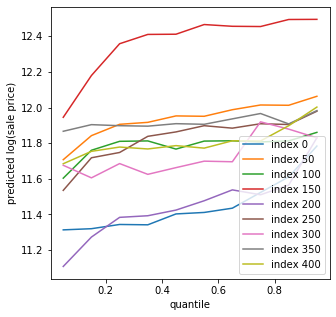

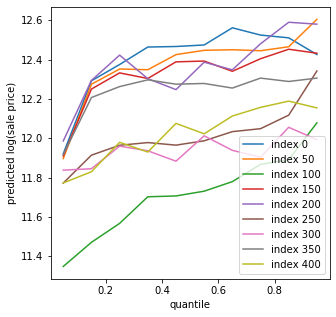

In [10]:
def plot_quantile_vs_pred(quantiles, preds, indexes):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))

    for idx in indexes:
        prd = [pred[idx] for pred in preds]
        ax.plot(quantiles, prd, label=f'index {idx}')

    ax.set_xlabel('quantile')
    ax.set_ylabel('predicted log(sale price)')
    ax.legend()
    fig.show()

print('train')
plot_quantile_vs_pred(quantiles, 
                      tr_pred_qps,
                      indexes=(0,50,100,150,200,250,300,350,400))

print('test')
plot_quantile_vs_pred(quantiles, 
                      ts_pred_qps,
                      indexes=(0,50,100,150,200,250,300,350,400))


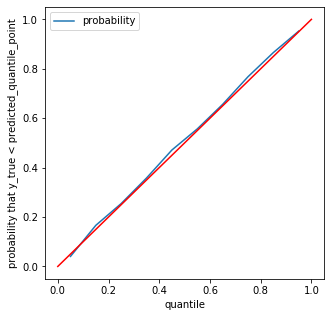

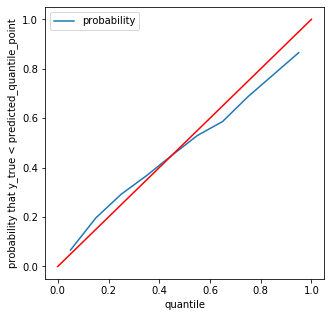

In [11]:
def plot_proba_less_than_quantile_point(quantiles, y_true, pred_list):
    proba = []
    for pred in pred_list:
        prb = np.sum(y_true < pred) / len(y_true)
        proba.append(prb)

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.plot(quantiles, proba, label='probability')
    ax.plot([0, 1], [0, 1], ls='-', c='r')

    ax.set_xlabel('quantile')
    ax.set_ylabel('probability that y_true < predicted_quantile_point')
    ax.legend()
    fig.show()

plot_proba_less_than_quantile_point(quantiles, tr_y, tr_pred_qps)
plot_proba_less_than_quantile_point(quantiles, ts_y, ts_pred_qps)

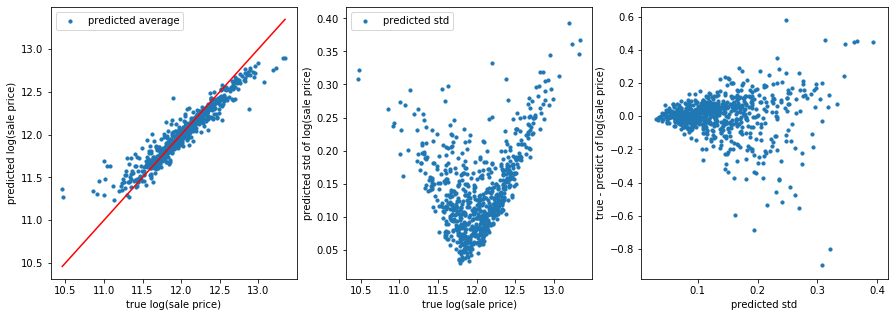

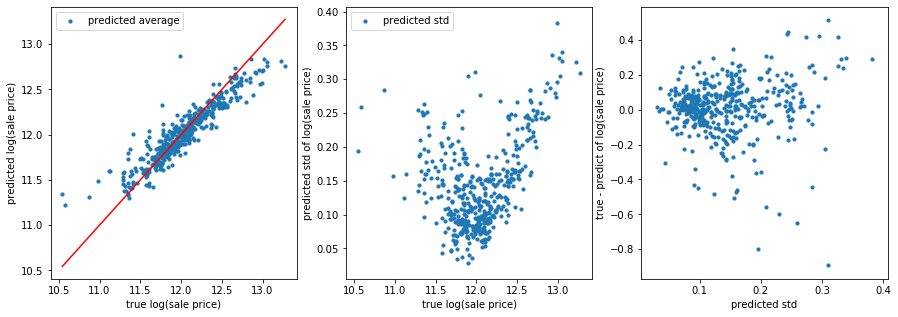

In [12]:
def plot_error(y_true, pred_ave, pred_std):
    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    ax = axs[0]
    ax.scatter(y_true, pred_ave, s=10, label='predicted average')
    ax.plot([np.min(y_true), np.max(y_true)], [np.min(y_true), np.max(y_true)], ls='-', c='r')
    ax.set_xlabel('true log(sale price)')
    ax.set_ylabel('predicted log(sale price)')
    ax.legend()

    ax = axs[1]
    ax.scatter(y_true, pred_std, s=10, label='predicted std')
    ax.set_xlabel('true log(sale price)')
    ax.set_ylabel('predicted std of log(sale price)')
    ax.legend()

    ax = axs[2]
    ax.scatter(pred_std, y_true - pred_ave, s=10)
    ax.set_xlabel('predicted std')
    ax.set_ylabel('true - predict of log(sale price)')

    fig.show()

plot_error(tr_y, tr_pred_ave, tr_pred_std)
plot_error(ts_y, ts_pred_ave, ts_pred_std)